In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import random
from matplotlib.colors import ListedColormap

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X_data, y_labels = datasets.make_classification(n_features=2, n_informative=2, 
                                                n_classes=2, n_redundant=0, 
                                                n_clusters_per_class=1, 
                                                random_state=5)

train_data, test_data, train_labels, test_labels = train_test_split(X_data, 
                                                                    y_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

#### 1. В коде из методички реализуйте один или несколько критериев останова: 
- минимальное количество объектов в листе (`min_leaf`), 
- максимальная глубина дерева, 
- максимальное количество листьев и т.д. 

Добавьте эти критерии в параметры функции `build_tree` и проверьте ее работоспособность с помощью визуализации дерева (функция `print_tree()`). 

In [3]:
def build_tree_stop_criteria(data, labels, min_samples_leaf=1, max_depth=6, max_leaf_nodes=None):
    
    """Итоговая модифицированная функция построения дерева выглядит так.
       Я проверял её на модели из урока. Работает корректно.
       Я не стал заморачиваться с критерием 'максимального количества листьев в дереве'.
       Чтобы довести работу функции с этим критерием до ума потребовалось бы много времени + неинтересно. 
       Я лучше потрачу время на остальные задания)))
    """
    
    
    min_leaf = min_samples_leaf
    quality, t, index = find_best_split(data, labels, min_samples_leaf=min_leaf)

    if (t is None) or (index is None):
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    if (len(true_data) <= min_samples_leaf) or (len(false_data) <= min_samples_leaf):
        return Leaf(data, labels)

    if max_depth is not None:
        if max_depth != 0:
            max_d = max_depth - 1
            true_branch = build_tree_stop_criteria(true_data, true_labels, 
                                               min_samples_leaf=min_leaf, max_depth=max_d)
            false_branch = build_tree_stop_criteria(false_data, false_labels, 
                                                min_samples_leaf=min_leaf, max_depth=max_d)
        else:
            return Leaf(data, labels)
    else:
        true_branch = build_tree_stop_criteria(true_data, true_labels, min_samples_leaf=min_leaf)
        false_branch = build_tree_stop_criteria(false_data, false_labels, min_samples_leaf=min_leaf)

    return Node(index, t, true_branch, false_branch)

Я попробовал применить в качестве критерия останова максимальное количество листьев в дереве `max_leaf_nodes`, но решение мне показалось довольно громоздким: нужно или заранее (до построения дерева) знать сколько листьев будет чтобы что-то предпринять или же нужно будет после построения дерева посчитать сколько листьев получилось и образать лишние, у которых метрики самые плохие - это тоже нужно заморочиться.

Однако есть одна мысль. Поскольку каждая ветка и каждый узел заканчивается листом и учитывая, что наше дерево строиться бинарным делением - количество листов зависим от количество нодов и, следоватеьно, от количества уровней. Максимальное количество листьев при $n$ уровнях равно $2^n$, но может быть и меньше, т.к. некоторые ветки могут обрываться не доходя до самого нижнего уровня.

Следовательно можно попытаться учитывать количество листьев при построении нового уровня. Позже к этому вернусь.

---
не буду использовать этот критерий.

##### Ниже - Модель (все функции в одной ячейке) взятая из урока для проверки корректности работы новой функции: `build_tree_stop_criteria`

In [4]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch
        

class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0 
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction

    
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity


def quality(left_labels, right_labels, current_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels, min_samples_leaf=5):
    min_leaf = min_samples_leaf
    current_gini = gini(labels)
    best_quality = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    for index in range(n_features):
        t_values = np.unique([row[index] for row in data])
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            current_quality = quality(true_labels, false_labels, current_gini)
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
    return best_quality, best_t, best_index

In [5]:
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

def print_tree(node, spacing=""):
    if isinstance(node, Leaf):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return
    print(ColorText.GREEN + spacing + 'УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")

In [6]:
# строим дерево, визуализируем его и проверяем корректность работы.
my_tree = build_tree_stop_criteria(train_data, train_labels, 
                               min_samples_leaf=10, max_depth=6, max_leaf_nodes=None)
print_tree(my_tree)

УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
       ЛИСТ: прогноз = 0, объектов = 12
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30


Все работает корректно.

### 2. (\*) Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. 
Сравните качество классификации, сделайте выводы.

#### Ниже (в рамках второго задания) пытаюсь построить ООП-модель на базе функций использованных на уроке.

### Модель в ООП-стиле.

In [7]:
class my_DecisionTreeClassifier:
    
    def __init__(self, criterion="gini", min_samples_leaf=1, max_leaf_nodes=None):
        self.criterion = criterion
        self.min_samples_leaf = min_samples_leaf
        self.max_leaf_nodes = max_leaf_nodes
        
    def fit(self, data, labels, max_depth=None):
        self.max_depth = max_depth
        quality, t, index = Node.find_best_split(self, data, labels)
        if (t is None) or (index is None):
            return Leaf(data, labels)
        true_data, false_data, true_labels, false_labels = Node.split(data, labels, index, t)
        if (len(true_data) <= self.min_samples_leaf) or (len(false_data) <= self.min_samples_leaf):
            return Leaf(data, labels)
        if max_depth is not None:
            if max_depth != 0:
                max_d = max_depth - 1
                true_branch = my_DecisionTreeClassifier.fit(self, true_data, true_labels, 
                                                            max_depth=max_d)
                false_branch = my_DecisionTreeClassifier.fit(self, false_data, false_labels, 
                                                             max_depth=max_d)
            else:
                return Leaf(data, labels)
        else:
            true_branch = my_DecisionTreeClassifier.fit(self, true_data, true_labels)
            false_branch = my_DecisionTreeClassifier.fit(self, false_data, false_labels)
        self.dtree = Node(index, t, true_branch, false_branch)
        # т.е. метод fit() возвращает атрибут объекта classifier (экземпляра класса 
        # my_DecisionTreeClassifier) содержащий обученный экземпляр дерева (объекта класса Node),
        # т.е. обученное дерево.
        return self.dtree
    
    @staticmethod
    def classify_obj(obj, node):
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer
        if obj[node.index] <= node.t:
            return my_DecisionTreeClassifier.classify_obj(obj, node.true_branch)
        else:
            return my_DecisionTreeClassifier.classify_obj(obj, node.false_branch)
    
    def labels_predict(self, X):
        pred_vec = []
        for obj in X:
            pred_val = my_DecisionTreeClassifier.classify_obj(obj, self.dtree)
            pred_vec.append(pred_val)
        return pred_vec
    
######    
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0 
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction
    
######    
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

    @staticmethod
    def gini(labels):
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
        return impurity
    
    @staticmethod
    def entropy(labels):
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        entropy_index = 0
        for label in classes:
            p = classes[label] / len(labels)
            entropy_index -= 0 if p == 0 else p*np.log2(p)
        return entropy_index

    @staticmethod
    def quality(left_labels, right_labels, criterion, current_criteria):
        weig = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        if criterion == 'gini':
            return current_criteria - weig * Node.gini(left_labels) \
                                                                - (1 - weig) * Node.gini(right_labels)
        elif criterion == 'entropy':
            return current_criteria - weig * Node.entropy(left_labels) \
                                                                - (1 - weig) * Node.entropy(right_labels)
    
    @staticmethod
    def split(data, labels, index, t):
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        return true_data, false_data, true_labels, false_labels
    
    def find_best_split(self, data, labels):
        if self.criterion == 'gini':
            current_criteria = Node.gini(labels)
        elif self.criterion == 'entropy':
            current_criteria = Node.entropy(labels)
        best_quality = 0
        best_t = None
        best_index = None
        n_features = data.shape[1]
        for index in range(n_features):
            t_values = np.unique([row[index] for row in data])
            for t in t_values:
                true_data, false_data, true_labels, false_labels = Node.split(data, labels, index, t)
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue
                current_quality = Node.quality(true_labels, false_labels, 
                                               self.criterion, current_criteria)
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
        return best_quality, best_t, best_index

    @staticmethod
    def accuracy_metric(actual, predicted):
        correct = 0
        for i in range(len(actual)):
            if actual[i] == predicted[i]:
                correct += 1
        return correct / float(len(actual))

In [8]:
my_cls = my_DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5)
my_cls.fit(train_data, train_labels, max_depth=None)
print_tree(my_cls.dtree)

УЗЕЛ: индекс = 0, порог = 0.16
--> Левая ветка:
   УЗЕЛ: индекс = 1, порог = -1.52
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = -0.95
      --> Левая ветка:
          ЛИСТ: прогноз = 0, объектов = 6
      --> Правая ветка:
          ЛИСТ: прогноз = 1, объектов = 6
   --> Правая ветка:
       ЛИСТ: прогноз = 0, объектов = 28
--> Правая ветка:
    ЛИСТ: прогноз = 1, объектов = 30


##### Ну вроде работает также как в функциональном стиле)))

Убил на это ну очень много времени (((

In [9]:
print(f"Проверка, предсказание для n-го объекта: {my_cls.classify_obj(train_data[4], my_cls.dtree):.0f}")
print(f"Проверка, критерий Gini: {my_cls.dtree.gini(np.array([0]*6 + [1]*8)):.4f}")
print(f"Проверка, еще раз критерий Gini: {Node.gini(np.array([0]*6 + [1]*8)):.4f}")

Проверка, предсказание для n-го объекта: 1
Проверка, критерий Gini: 0.4898
Проверка, еще раз критерий Gini: 0.4898


In [10]:
train_answers = my_cls.labels_predict(train_data)
test_answers = my_cls.labels_predict(test_data)

In [11]:
print(f"train_metric: {my_cls.dtree.accuracy_metric(train_labels, train_answers):.4f}")
print(f"test_metric:  {my_cls.dtree.accuracy_metric(test_labels, test_answers):.4f}")

train_metric: 0.9857
test_metric:  1.0000


### Вывод по второму заданию:
<font size=4 color="green">Метрики на основе критерия gini и энтропии Шеннона ведут себя практически идентично.</font>

На данном игрушечном датасете разницы вообще не видно, метрики равны на столько, что я усомнился, что сделал все правильно.

#### 3\*. Реализуйте дерево для задачи регрессии.
Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений. Проверьте точность предсказания дерева на одной из метрик задачи регрессии.

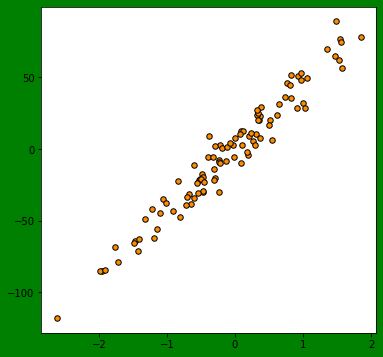

In [12]:
# 3 задание
from sklearn import datasets

regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                              n_features=1, 
                                                              noise=10, 
                                                              random_state=42)

plt.figure(figsize=(6,6), facecolor="g")
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=30);

In [13]:
train_X, test_X, train_y, test_y = train_test_split(regression_data, regression_labels, 
                                                    test_size=.3, random_state=6)

In [14]:
class my_DecisionTreeRegressor:
    
    def __init__(self, criterion="mse", min_samples_leaf=1, max_leaf_nodes=None):
        self.criterion = criterion
        self.min_samples_leaf = min_samples_leaf
        self.max_leaf_nodes = max_leaf_nodes
        
    def reg_fit(self, X, y, max_depth=None):
        self.max_depth = max_depth
        quality, t, index = Node_reg.reg_find_best_split(self, X, y)
        if (t is None) or (index is None):
            return Leaf_reg(X, y)
        true_X, false_X, true_y, false_y = Node_reg.reg_split(X, y, index, t)
        if (len(true_X) <= self.min_samples_leaf) or (len(false_X) <= self.min_samples_leaf):
            return Leaf_reg(X, y)
        if max_depth is not None:
            if max_depth != 0:
                max_d = max_depth - 1
                true_branch = my_DecisionTreeRegressor.reg_fit(self, true_X, true_y, max_depth=max_d)
                false_branch = my_DecisionTreeRegressor.reg_fit(self, false_X, false_y, max_depth=max_d)
            else:
                return Leaf_reg(X, y)
        else:
            true_branch = my_DecisionTreeRegressor.reg_fit(self, true_X, true_y)
            false_branch = my_DecisionTreeRegressor.reg_fit(self, false_X, false_y)
        self.reg_dtree = Node_reg(index, t, true_branch, false_branch)
        # т.е. метод reg_fit() возвращает атрибут объекта regressor (экземпляр класса 
        # my_DecisionTreeRegressor) содержащий обученный экземпляр объекта дерева (класса Node); 
        # попросту говоря возвращает обученное дерево;
        return self.reg_dtree
    
    @staticmethod
    def predict_obj(obj, node):
        if isinstance(node, Leaf_reg):
            answer = node.pred_value
            return answer
        if obj[node.index] <= node.t:
            return my_DecisionTreeRegressor.predict_obj(obj, node.true_branch)
        else:
            return my_DecisionTreeRegressor.predict_obj(obj, node.false_branch)
    
    def reg_predict(self, X):
        pred_vec = []
        for obj in X:
            pred_val = my_DecisionTreeRegressor.predict_obj(obj, self.reg_dtree)
            pred_vec.append(pred_val)
        return pred_vec

    
######    
class Leaf_reg:
    def __init__(self, X, y):
        self.feat_values = X
        self.targ_values = y
        self.pred_value = np.mean(self.targ_values)


######    
class Node_reg:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

    @staticmethod
    def reg_quality(targ_val_l, targ_val_r, disp_curr):
        disp_left = np.var(targ_val_l)
        disp_righ = np.var(targ_val_r)
        weig = float(targ_val_l.shape[0]) / (targ_val_l.shape[0] + targ_val_r.shape[0])
        return disp_curr - weig * disp_left - (1 - weig) * disp_righ
    
    @staticmethod
    def reg_split(X, y, index, t):
        left = np.where(X[:, index] <= t)
        right = np.where(X[:, index] > t)
        true_X = X[left]
        false_X = X[right]
        true_y = y[left]
        false_y = y[right]
        return true_X, false_X, true_y, false_y
    
    def reg_find_best_split(self, X, y):
        disp_curr = np.var(y)
        best_quality = 0
        best_t = None
        best_index = None
        n_features = X.shape[1]
        for index in range(n_features):
            t_values = np.unique([row[index] for row in X])
            for t in t_values:
                true_X, false_X, true_y, false_y = Node_reg.reg_split(X, y, index, t)
                if len(true_X) < self.min_samples_leaf or len(false_X) < self.min_samples_leaf:
                    continue
                current_quality = Node_reg.reg_quality(true_y, false_y, disp_curr)
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
        return best_quality, best_t, best_index

    @staticmethod
    def mse_metric(actual, predicted):
        return np.mean((actual - predicted) ** 2)
    

######
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

def reg_print_tree(node, spacing=""):
    if isinstance(node, Leaf_reg):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.pred_value) 
                  + ', объектов = ' + str(len(node.targ_values)) 
                  + ColorText.END)
        return
    print(ColorText.GREEN + spacing + 'УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)
    print (spacing + '--> Левая ветка:')
    reg_print_tree(node.true_branch, spacing + "   ")
    print (spacing + '--> Правая ветка:')
    reg_print_tree(node.false_branch, spacing + "   ")

In [15]:
my_reg = my_DecisionTreeRegressor(min_samples_leaf=5)
my_reg.reg_fit(train_X, train_y, max_depth=None)
reg_print_tree(my_reg.reg_dtree)

УЗЕЛ: индекс = 0, порог = -0.23
--> Левая ветка:
   УЗЕЛ: индекс = 0, порог = -1.41
   --> Левая ветка:
       ЛИСТ: прогноз = -75.59835646812401, объектов = 7
   --> Правая ветка:
      УЗЕЛ: индекс = 0, порог = -0.6
      --> Левая ветка:
          ЛИСТ: прогноз = -40.244173819607866, объектов = 9
      --> Правая ветка:
         УЗЕЛ: индекс = 0, порог = -0.46
         --> Левая ветка:
             ЛИСТ: прогноз = -23.03151004690616, объектов = 9
         --> Правая ветка:
             ЛИСТ: прогноз = -16.787450578114036, объектов = 6
--> Правая ветка:
   УЗЕЛ: индекс = 0, порог = 0.65
   --> Левая ветка:
      УЗЕЛ: индекс = 0, порог = 0.31
      --> Левая ветка:
         УЗЕЛ: индекс = 0, порог = -0.01
         --> Левая ветка:
             ЛИСТ: прогноз = -0.8281855692554628, объектов = 6
         --> Правая ветка:
             ЛИСТ: прогноз = 4.6111705563669405, объектов = 11
      --> Правая ветка:
          ЛИСТ: прогноз = 22.57747521692777, объектов = 7
   --> Правая ветка:
 

In [16]:
train_X[0]

array([0.96864499])

In [17]:
my_reg.predict_obj(train_X[0], my_reg.reg_dtree)
train_pred = my_reg.reg_predict(train_X)
test_pred = my_reg.reg_predict(test_X)
print(f"train_mse_metric: {my_reg.reg_dtree.mse_metric(train_y, train_pred):.4f}")
print(f"test_mse_metric: {Node_reg.mse_metric(test_y, test_pred):.4f}")

train_mse_metric: 84.2552
test_mse_metric: 108.6150


In [18]:
metrics = []
for param in range(1, 7):
    my_reg = my_DecisionTreeRegressor(min_samples_leaf=param)
    my_reg.reg_fit(train_X, train_y, max_depth=4)
    train_pred = my_reg.reg_predict(train_X)
    test_pred = my_reg.reg_predict(test_X)
    metrics.append((my_reg.reg_dtree.mse_metric(train_y, train_pred), 
                    Node_reg.mse_metric(test_y, test_pred)))
print(np.array(metrics))

[[ 77.74351303 104.10960417]
 [ 78.79791376 102.61196961]
 [ 83.46959329 111.93433245]
 [ 85.89613127 111.98016416]
 [ 84.25519406 108.61503032]
 [ 87.90124274 129.59079829]]


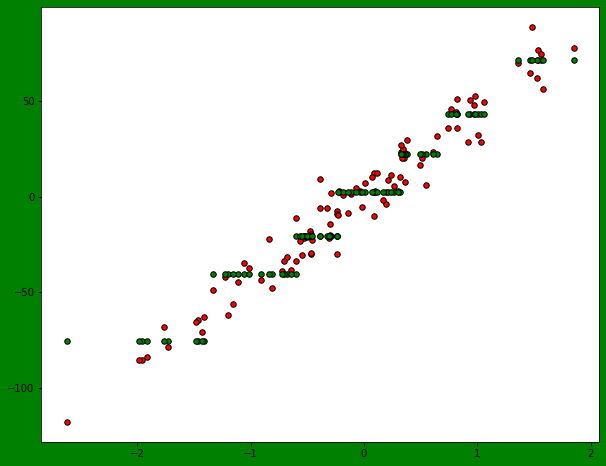

In [19]:
regression_pred = my_reg.reg_predict(regression_data)
plt.figure(figsize=(10,8), facecolor="g")
plt.scatter(regression_data, regression_labels, c="red", edgecolor="black", s=30)
plt.scatter(regression_data, regression_pred, c="green", edgecolor="black", s=30)

#### В целом модель "ухватила" закономерность в данных. Интересно что получился такой ступенчатый ответ.

PS/
Пространства имен модели классификации и регрессии перекрываются.

Если выполнить ячейку с моделью классификации, то потом выдают ошибку обращения к методом регрессионной модели и наоборот, если последней выполенна ячейка с кодом регрессионной модели, корректно работают обращения к методам регрессионной модели, а сбоят обращения к методам модели классификации.

Я постарался переназвать методы в регрессионной модели добавлением префикса `reg_`

<font color="green">Теперь всё работает как надо!))))</font>